# Setup


If you are running this generator locally(i.e. in a jupyter notebook in conda, just make sure you installed:
- RDKit
- DeepChem 2.5.0 & above
- Tensorflow 2.4.0 & above

Then, please skip the following part and continue from `Data Preparations`.

To increase efficiency, we recommend running this molecule generator in Colab.

Then, we'll first need to run the following lines of code, these will download conda with the deepchem environment in colab.

In [1]:
#!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
#import conda_installer
#conda_installer.install()
#!/root/miniconda/bin/conda info -e

In [2]:
#!pip install --pre deepchem
#import deepchem
#deepchem.__version__

# Data Preparations

Now we are ready to import some useful functions/packages, along with our model.

## Import Data

In [3]:
import model##our model

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import deepchem as dc 

Then, we are ready to import our dataset for training. 

Here, for demonstration, we'll be using this dataset of in-vitro assay that detects inhibition of SARS-CoV 3CL protease via fluorescence.

The dataset is originally from [PubChem AID1706](https://pubchem.ncbi.nlm.nih.gov/bioassay/1706), previously handled by [JClinic AIcure](https://www.aicures.mit.edu/) team at MIT into this [binarized label form](https://github.com/yangkevin2/coronavirus_data/blob/master/data/AID1706_binarized_sars.csv).

In [7]:
df = pd.read_csv('AID1706_binarized_sars.csv')

In [8]:
df.head()

,smiles,activity
0,CC1=CC=C(O1)C(C(=O)NCC2=CC=CO2)N(C3=CC=C(C=C3)...,1
1,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)S(=O)(=O)C3=C...,1
2,CC1=CC2=C(C=C1)NC(=O)C(=C2)CN(CCC3=CC=CC=C3)CC...,1
3,CC1=CC=C(C=C1)CN(C(C2=CC=CS2)C(=O)NCC3=CC=CO3)...,1
4,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,1


In [9]:
df.groupby('activity').count()

,smiles
activity,
0,290321
1,405


Observe the data above, it contains a 'smiles' column, which stands for the smiles representation of the molecules. There is also an 'activity' column, in which it is the label specifying whether that molecule is considered as hit for the protein.

Here, we only need those 405 molecules considered as hits, and we'll be extracting features from them to generate new molecules that may as well be hits.

In [10]:
true = df[df['activity']==1]

## Set Minimum Length for molecules

Since we'll be using graphic neural network, it might be more helpful and efficient if our graph data are of the same size, thus, we'll eliminate the molecules from the training set that are shorter(i.e. lacking enough atoms) than our desired minimum size.

In [11]:
num_atoms = 6 #here the minimum length of molecules is 6

In [12]:
input_df = true['smiles']
df_length = []
for _ in input_df:
    df_length.append(Chem.MolFromSmiles(_).GetNumAtoms() )

In [13]:
true['length'] = df_length #create a new column containing each molecule's length

/Users/feishu/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
true = true[true['length']>num_atoms] #Here we leave only the ones longer than 6
input_df = true['smiles']
input_df_smiles = input_df.apply(Chem.MolFromSmiles) #convert the smiles representations into rdkit molecules


Now, we are ready to apply the `featurizer` function to our molecules to convert them into graphs with nodes and edges for training.

In [15]:
#input_df = input_df.apply(Chem.MolFromSmiles) 
train_set = input_df_smiles.apply( lambda x: model.featurizer(x,max_length = num_atoms))

In [16]:
train_set

0      ([6, 6, 6, 6, 6, 8], [[0, 2, 0, 0, 0, 0], [2, ...
1      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
2      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
3      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
4      ([6, 6, 7, 6, 7, 6], [[0, 2, 0, 0, 0, 0], [2, ...
                             ...                        
400    ([6, 6, 8, 6, 6, 8], [[0, 2, 0, 0, 0, 2], [2, ...
401    ([6, 8, 6, 8, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
402    ([6, 8, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
403    ([6, 7, 6, 6, 6, 7], [[0, 2, 0, 0, 0, 0], [2, ...
404    ([6, 6, 8, 6, 7, 16], [[0, 2, 0, 0, 2, 0], [2,...
Name: smiles, Length: 405, dtype: object

In [17]:
nodes_train, edges_train = list(zip(*train_set) )

# Training

Now, we're finally ready for generating new molecules. We'll first import some necessay functions from tensorflow.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The network here we'll be using is Generative Adversarial Network, here's a great [introduction](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/). 

![Screen Shot 2021-06-08 at 7 40 49 PM](https://user-images.githubusercontent.com/67823308/121178738-709bbd80-c891-11eb-91dc-d45e69f8f4d5.png)


In [19]:
disc = model.make_discriminator(num_atoms)

In [20]:
gene = model.make_generator(num_atoms, noise_input_shape = 100)

>0, d1=0.224, d2=0.415 g=1.139, a1=100, a2=100
>1, d1=0.096, d2=0.616 g=0.800, a1=100, a2=100
>2, d1=0.096, d2=0.838 g=0.568, a1=100, a2=0
>3, d1=0.096, d2=1.076 g=0.434, a1=100, a2=0
>4, d1=0.165, d2=1.347 g=0.308, a1=100, a2=0
>5, d1=0.060, d2=1.600 g=0.204, a1=100, a2=0
>6, d1=0.224, d2=1.924 g=0.147, a1=100, a2=0
>7, d1=0.074, d2=2.275 g=0.108, a1=100, a2=0
>8, d1=0.830, d2=2.444 g=0.088, a1=0, a2=0
>9, d1=5.003, d2=2.798 g=0.068, a1=0, a2=0
>10, d1=0.124, d2=2.924 g=0.053, a1=100, a2=0
>11, d1=0.200, d2=3.263 g=0.042, a1=100, a2=0
>12, d1=0.074, d2=3.421 g=0.035, a1=100, a2=0
>13, d1=0.096, d2=3.541 g=0.030, a1=100, a2=0
>14, d1=0.060, d2=3.668 g=0.026, a1=100, a2=0
>15, d1=0.060, d2=3.744 g=0.025, a1=100, a2=0
>16, d1=1.008, d2=3.862 g=0.021, a1=0, a2=0
>17, d1=0.356, d2=3.975 g=0.020, a1=100, a2=0
>18, d1=0.053, d2=4.004 g=0.019, a1=100, a2=0
>19, d1=0.096, d2=3.994 g=0.017, a1=100, a2=0
>20, d1=0.181, d2=4.139 g=0.017, a1=100, a2=0
>21, d1=0.265, d2=4.113 g=0.016, a1=100, a2=0


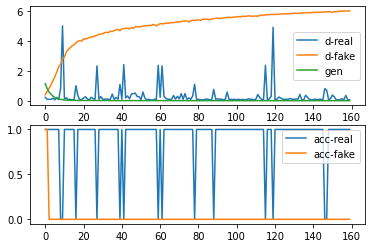

In [49]:
generator_trained = model.train_batch(
                                disc, gene, 
                                np.array(nodes_train), np.array(edges_train), 
                                noise_input_shape = 100, EPOCH = 160, BATCHSIZE = 2, 
                                plot_hist = True, temp_result = False
    )

In [50]:
no, ed = generator_trained(np.random.randint(0,30, size =(1,100)))

In [56]:
abs(no.numpy()).astype(int).reshape(num_atoms), abs(ed.numpy()).astype(int).reshape(num_atoms,num_atoms)

(array([5, 4, 5, 8, 5, 8]),
 array([[0, 2, 0, 0, 0, 0],
        [3, 0, 3, 0, 0, 0],
        [0, 2, 0, 1, 0, 0],
        [0, 1, 2, 1, 3, 1],
        [1, 0, 0, 4, 0, 2],
        [1, 0, 1, 1, 3, 0]]))

In [52]:
cat, dog = model.de_featurizer(abs(no.numpy()).astype(int).reshape(num_atoms), abs(ed.numpy()).astype(int).reshape(num_atoms,num_atoms))

In [58]:
Chem.MolToSmiles(mol)

NameError: name 'mol' is not defined

In [54]:
Chem.MolToSmiles(cat)

'B[Be]=B~O=BO'

In [55]:
Chem.MolFromSmiles("B=[Be]BO#B=O")

RDKit ERROR: [21:35:46] Explicit valence for atom # 1 Be, 3, is greater than permitted
